In [1]:
##[2주차] 기본과제: 주어진 문장에서 나올 다음 단어를 예측하는 모델 구현

Using cache found in /Users/nabakgood/.cache/torch/hub/huggingface_pytorch-transformers_main


Epoch 1: Train Loss: 1485.4798
Train Accuracy: 0.558 | Test Accuracy: 0.564
Epoch 2: Train Loss: 1166.1857
Train Accuracy: 0.558 | Test Accuracy: 0.564
Epoch 3: Train Loss: 1115.8106
Train Accuracy: 0.558 | Test Accuracy: 0.564
Epoch 4: Train Loss: 1070.4838
Train Accuracy: 0.558 | Test Accuracy: 0.564
Epoch 5: Train Loss: 1056.9149
Train Accuracy: 0.558 | Test Accuracy: 0.563
Epoch 6: Train Loss: 1045.4136
Train Accuracy: 0.559 | Test Accuracy: 0.564
Epoch 7: Train Loss: 1041.4097
Train Accuracy: 0.560 | Test Accuracy: 0.560
Epoch 8: Train Loss: 1033.5400
Train Accuracy: 0.559 | Test Accuracy: 0.564
Epoch 9: Train Loss: 1029.9730
Train Accuracy: 0.559 | Test Accuracy: 0.562
Epoch 10: Train Loss: 1026.1199
Train Accuracy: 0.560 | Test Accuracy: 0.564


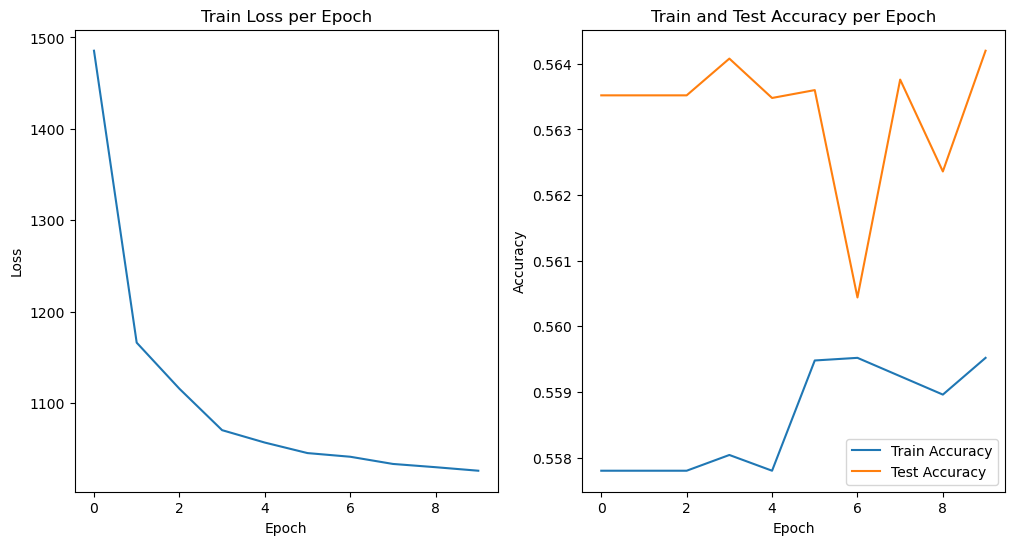

In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from torch.optim import Adam
from math import sqrt
from datasets import load_dataset
from torch.utils.data import DataLoader
from transformers import BertTokenizerFast
from torch.nn.utils.rnn import pad_sequence
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)


ds = load_dataset("stanfordnlp/imdb")
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'bert-base-uncased')

# 새로운 collate_fn 정의
def collate_fn(batch):
    max_len = 400
    texts, labels = [], []
    for row in batch:
        labels.append(tokenizer(row['text'], truncation=True, max_length=max_len).input_ids[-2])
        texts.append(torch.LongTensor(tokenizer(row['text'], truncation=True, max_length=max_len).input_ids[:-2]))

    texts = pad_sequence(texts, batch_first=True, padding_value=tokenizer.pad_token_id)
    labels = torch.LongTensor(labels)

    return texts, labels

# DataLoader 정의
train_loader = DataLoader(ds['train'], batch_size=64, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(ds['test'], batch_size=64, shuffle=False, collate_fn=collate_fn)


# Transformer 모델 구현
class TransformerLayer(nn.Module):
    def __init__(self, input_dim, d_model, dff):
        super().__init__()

        self.input_dim = input_dim
        self.d_model = d_model
        self.dff = dff

        self.sa = SelfAttention(input_dim, d_model)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, dff),
            nn.ReLU(),
            nn.Linear(dff, d_model)
        )

    def forward(self, x, mask):
        x = self.sa(x, mask)
        x = self.ffn(x)
        return x

class SelfAttention(nn.Module):
    def __init__(self, input_dim, d_model):
        super().__init__()

        self.input_dim = input_dim
        self.d_model = d_model

        self.wq = nn.Linear(input_dim, d_model)
        self.wk = nn.Linear(input_dim, d_model)
        self.wv = nn.Linear(input_dim, d_model)
        self.dense = nn.Linear(d_model, d_model)

        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, mask):
        q, k, v = self.wq(x), self.wk(x), self.wv(x)
        score = torch.matmul(q, k.transpose(-1, -2))  # (B, S, D) * (B, D, S) = (B, S, S)
        score = score / sqrt(self.d_model)

        if mask is not None:
            score = score + (mask * -1e9)

        score = self.softmax(score)
        result = torch.matmul(score, v)
        result = self.dense(result)

        return result


class TextClassifier(nn.Module):
    def __init__(self, vocab_size, d_model, n_layers, dff):
        super().__init__()

        self.vocab_size = vocab_size
        self.d_model = d_model
        self.n_layers = n_layers
        self.dff = dff

        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = nn.Parameter(positional_encoding(400, d_model), requires_grad=False)
        self.layers = nn.ModuleList([TransformerLayer(d_model, d_model, dff) for _ in range(n_layers)])

        # 출력 크기를 vocab_size로 설정하여 각 단어의 확률을 예측
        self.classification = nn.Linear(d_model, vocab_size)  # vocab_size로 수정

    def forward(self, x):
        mask = (x == tokenizer.pad_token_id)
        mask = mask[:, None, :]
        seq_len = x.shape[1]

        x = self.embedding(x)
        x = x * sqrt(self.d_model)
        x = x + self.pos_encoding[:, :seq_len]

        for layer in self.layers:
            x = layer(x, mask)

        x = x[:, 0]  # 첫 번째 토큰만 사용 (BERT에서 [CLS] 토큰)
        x = self.classification(x)  # vocab_size 크기의 출력을 만듦

        return x


# Positional encoding 함수 정의
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, None], np.arange(d_model)[None, :], d_model)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[None, ...]

    return torch.FloatTensor(pos_encoding)


# 모델 초기화
device = torch.device('mps')

model = TextClassifier(len(tokenizer), 32, 2, 32)
model = model.to(device)

# 손실 함수 및 옵티마이저 정의
loss_fn = nn.CrossEntropyLoss()  # CrossEntropyLoss 사용
optimizer = Adam(model.parameters(), lr=0.001)  

# 정확도 계산 함수
def accuracy(model, dataloader):
    cnt = 0
    acc = 0

    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # 모델 예측
        preds = model(inputs)  # 모델의 예측값 (batch_size, vocab_size)

        # 예측값에서 가장 높은 확률의 클래스 인덱스 추출
        _, predicted = torch.max(preds, dim=-1)  # (batch_size,)

        # 정확도 계산
        cnt += labels.shape[0]
        acc += (predicted == labels).sum().item()

    return acc / cnt

# 학습
n_epochs = 10
train_losses, train_accs, test_accs = [], [], []

for epoch in range(n_epochs):
    total_loss = 0.
    model.train()
    # 학습 루프 내에서 손실 계산 부분 수정
    for data in train_loader:
        model.zero_grad()
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # 모델 예측
        preds = model(inputs)  # 모델의 예측값

        # CrossEntropyLoss는 logits을 입력으로 받으므로 reshape하지 않음
        loss = loss_fn(preds, labels)  # preds: (batch_size, vocab_size), labels: (batch_size,)

        # 역전파 및 최적화
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}: Train Loss: {total_loss:.4f}")
    
    # 평가
    with torch.no_grad():
        model.eval()
        train_acc = accuracy(model, train_loader)
        test_acc = accuracy(model, test_loader)
        print(f"Train Accuracy: {train_acc:.3f} | Test Accuracy: {test_acc:.3f}")

    train_losses.append(total_loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)


# 학습 결과 시각화
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(n_epochs), train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss per Epoch')

plt.subplot(1, 2, 2)
plt.plot(range(n_epochs), train_accs, label='Train Accuracy')
plt.plot(range(n_epochs), test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train and Test Accuracy per Epoch')

plt.show()

#결과